In [22]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, quickshift
from scipy import ndimage
import numpy as np
import argparse
import matplotlib.pyplot as plt


def label_all_segs(segmentation, 
                   structure=np.array([[0,1,0],[1,1,1],[0,1,0]])):
    unique_labels = np.unique(segmentation)

    new_label = 0
    new_segmentation = np.zeros_like(segmentation)
    for original_label in unique_labels:
        # if original_label == 0:
        #     continue  # skip background or noise, depending on your data
        binary_image = (segmentation == original_label)
        labeled_image, ncomponents = ndimage.label(binary_image, 
                                                   structure=structure)
        # The trick here is to add 'new_label' to the labeled image and subtract 1 to make sure that
        # the background in 'labeled_image' remains 0 in 'new_segmentation'
        new_segmentation += (labeled_image + new_label - 1) * binary_image
        new_label += ncomponents

    return new_segmentation

def apply_watershed(image, compactness=0):
    image = (image * 255).astype(np.uint8)
    distance = ndimage.distance_transform_edt(image)
    coords = peak_local_max(distance, min_distance=10, labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    raw_labels = watershed(-distance, markers, mask=image,
                           compactness=compactness)
    return raw_labels

def contour_segment_image(image,
                          method='watershed',
                          connect='diagonal', 
                          kernel_size=11, 
                          num_bins=10,
                          ratio=1.0,
                          max_dist=10,
                          compactness=0.01):
    if connect == 'straight':
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]])
    else: # diagonal
        structure = np.array([[1,1,1],[1,1,1],[1,1,1]])
    
    if method == 'watershed':
        raw_labels = apply_watershed(image, compactness)
    else:
        raise ValueError('Only watershed can be used now')
    
    seg_labels = label_all_segs(raw_labels, structure=structure)
    return seg_labels

In [20]:
import os

new_seg_dir = '../../data/processed/cosmogrid/masks'
os.makedirs(new_seg_dir, exist_ok=True)
input_filepath = '../../data/cosmogrid/X_maps_Cosmogrid_100k.npy'
output_filename = 'X_maps_Cosmogrid_100k_watershed_diagonal.npy'
output_filepath = os.path.join(new_seg_dir, output_filename)

In [21]:
import numpy as np

X = np.load(input_filepath, allow_pickle=True)

number of segments 52
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]


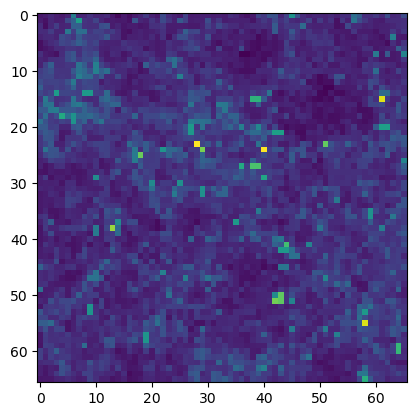

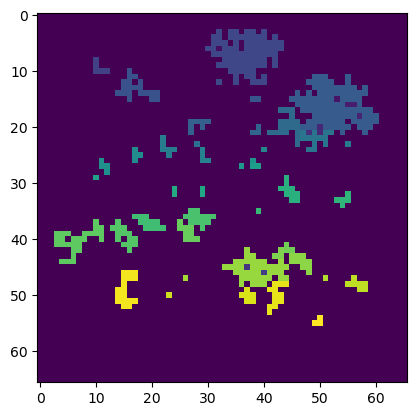

In [29]:
import matplotlib.pyplot as plt

i = 0
image = X[i]
mask = contour_segment_image(image)

print('number of segments', mask.max())
print(np.unique(mask))

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(mask)

In [31]:
from tqdm.auto import tqdm

masks = []
for i in tqdm(range(len(X))):
    image = X[i]
    mask = contour_segment_image(image)
    masks.append(mask)
masks = np.stack(masks, axis=0)

print('masks', masks.shape)
np.save(output_filepath, masks, allow_pickle=True)
print(f'Saved to {output_filepath}')

  0%|          | 0/100000 [00:00<?, ?it/s]

masks (100000, 66, 66)
Saved to ../data/processed/cosmogrid/masks/X_maps_Cosmogrid_100k_watershed_diagonal.npy
